In [23]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [25]:
pickle_file = 'SVHN.pickle'

with open(pickle_file, 'rb') as f:
    tmp_save = pickle.load(f)
    tmp_train_dataset = tmp_save['train_dataset']
    tmp_train_labels = tmp_save['train_labels']
    tmp_valid_dataset = tmp_save['valid_dataset']
    tmp_valid_labels = tmp_save['valid_labels']
    tmp_test_dataset = tmp_save['test_dataset']
    tmp_test_labels = tmp_save['test_labels']
    
    print('Training set', tmp_train_dataset.shape, tmp_train_labels.shape)
    print('Validation set', tmp_valid_dataset.shape, tmp_valid_labels.shape)
    print('Test set', tmp_test_dataset.shape, tmp_test_labels.shape)
    del tmp_save
    

Training set (20000, 90, 160) (20000,)
Validation set (2000, 90, 160) (2000,)
Test set (6000, 90, 160) (6000,)


In [26]:
# Lets only train on pics with n digits
num_digits = 1

keep = [i for i, label in enumerate(tmp_train_labels) if len(label) <= num_digits]
tmp_train_dataset = tmp_train_dataset[keep]
tmp_train_labels = tmp_train_labels[keep]

keep = [i for i, label in enumerate(tmp_valid_labels) if len(label) <= num_digits]
tmp_valid_dataset = tmp_valid_dataset[keep]
tmp_valid_labels = tmp_valid_labels[keep]

keep = [i for i, label in enumerate(tmp_test_labels) if len(label) <= num_digits]
tmp_test_dataset = tmp_test_dataset[keep]
tmp_test_labels = tmp_test_labels[keep]

print('Training set', tmp_train_dataset.shape, tmp_train_labels.shape)
print('Validation set', tmp_valid_dataset.shape, tmp_valid_labels.shape)
print('Test set', tmp_test_dataset.shape, tmp_test_labels.shape)

Training set (3032, 90, 160) (3032,)
Validation set (316, 90, 160) (316,)
Test set (938, 90, 160) (938,)


Labels [6]
Dtype float32
Shape (90, 160)
Color range -0.5 0.5


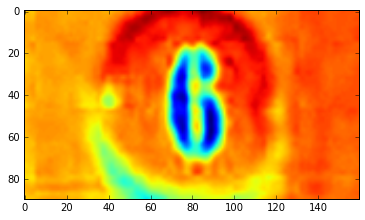

Labels [5]
Dtype float32
Shape (90, 160)
Color range -0.5 0.5


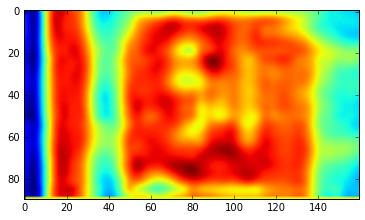

Labels [1]
Dtype float32
Shape (90, 160)
Color range -0.5 0.5


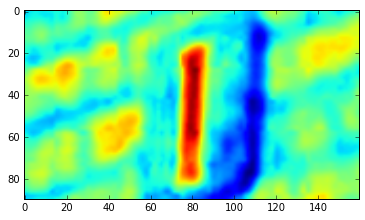

In [27]:
def show_image(img, label):
    print("Labels", label)
    print("Dtype", img.dtype)
    print("Shape", img.shape)
    print("Color range", np.min(img), np.max(img))
    plt.imshow(img)
    plt.show()
    
def show_images(imgs, labels, num=3):
    for i in range(num):
        num = np.random.randint(imgs.shape[0])
        show_image(imgs[num], labels[num])
    
show_images(tmp_train_dataset, tmp_train_labels, 1)
show_images(tmp_valid_dataset, tmp_valid_labels, 1)
show_images(tmp_test_dataset, tmp_test_labels, 1)

In [30]:
num_labels = 11 # Add an extra character so we can deal with spaces
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
    dataset_output = dataset.reshape(list(dataset.shape) + [1]).astype(np.float32)
    labels_output = np.array([np.array([(np.arange(num_labels) == l).astype(np.float32) 
                        for l in np.append(row, [num_labels-1] * (num_digits - len(row)), 0)])
              for row in labels])
    labels_output = np.reshape(labels_output, [labels_output.shape[0], -1])
    return dataset_output, labels_output

train_dataset, train_labels = reformat(tmp_train_dataset, tmp_train_labels)
valid_dataset, valid_labels = reformat(tmp_valid_dataset, tmp_valid_labels)
test_dataset, test_labels = reformat(tmp_test_dataset, tmp_test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (3032, 90, 160, 1) (3032, 11)
Validation set (316, 90, 160, 1) (316, 11)
Test set (938, 90, 160, 1) (938, 11)


Labels [1]
Dtype float32
Shape (90, 160)
Color range -0.5 0.5


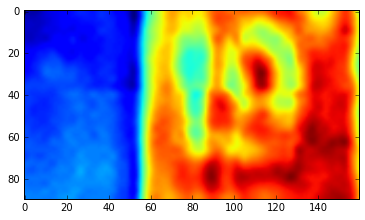

[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Labels [5]
Dtype float32
Shape (90, 160)
Color range -0.5 0.5


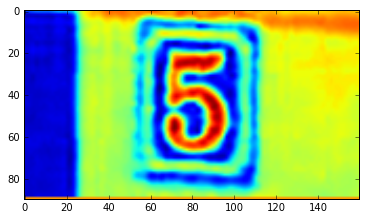

[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
Labels [3]
Dtype float32
Shape (90, 160)
Color range -0.5 0.5


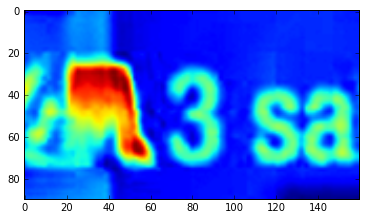

[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


In [31]:
for i in np.random.choice(range(tmp_train_labels.shape[0]), 3):
    show_image(tmp_train_dataset[i], tmp_train_labels[i])
    print(train_labels[i])

In [32]:
# Clean up after ourselves
%reset_selective -f tmp_.*

In [38]:
num_steps = 30001
batch_size = 50

patch_size = 5
depth = 32

patch_size2 = 5
depth2 = 64

# Taken from tensorflow tutorial
num_hidden = 1024

graph = tf.Graph()

img_height, img_width = test_dataset[0].shape[:2]
print(img_height, img_width)

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size,
                                                       img_height,
                                                       img_width,
                                                       num_channels), name="tf_train_dataset")

    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size,
                                                      num_labels * num_digits), name="tf_train_labels_%d" % i)
                     #for i in range(num_digits)]
    tf_valid_dataset = tf.constant(valid_dataset, name="tf_valid_dataset")
    tf_test_dataset = tf.constant(test_dataset, name="tf_test_dataset")

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                    patch_size,
                                                    num_channels,
                                                    depth], stddev=0.1), name="layer1_weights")
    layer1_biases = tf.Variable(tf.constant(0.1, shape=[depth]), name="layer1_biases")

    layer2_weights = tf.Variable(tf.truncated_normal([patch_size2,
                                                    patch_size2,
                                                    depth,
                                                    depth2], stddev=0.1), name="layer2_weights")
    layer2_biases = tf.Variable(tf.constant(0.1, shape=[depth2]), name="layer2_biases")

    layer3_weights = tf.Variable(tf.truncated_normal([60 * depth2, num_hidden], stddev=0.1), name="layer3_weights")

    layer3_biases = tf.Variable(tf.constant(0.1, shape=[num_hidden]), name="layer3_biases")

    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden,
                                                    num_labels * num_digits], stddev=0.1), name="layer4_weights")
                    #for i in range(num_digits)]
    layer4_biases = tf.Variable(tf.constant(0.1, shape=[num_labels * num_digits]), name="layer4_biases")
                   #for i in range(num_digits)]

    # Model.
    def model(data, dropout=False):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        
        # Taken from tensorflow tutorial
        hidden = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        
        # Taken from tensorflow tutorial
        hidden = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        shape = hidden.get_shape().as_list()

        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
                
        if dropout:
            hidden = tf.nn.dropout(hidden, 0.5)
            
        output = tf.matmul(hidden, layer4_weights) + layer4_biases
                  #for i in range(num_digits)]
        return output

    # Training computation.
    logits = model(tf_train_dataset, True)
    
    loss = tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(
                            logits,
                            tf_train_labels
                        ))
           #            for i in range(num_digits)]
    
    # Lets sum up the errors for each digit
    #loss = tf.add_n(loss_per_digit)
    #loss = tf.add_n(loss_per_digit)
    
    
    # Optimizer.
    #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.05, global_step, num_steps, 0.596)
    #learning_rate = tf.train.exponential_decay(0.10, global_step, 1001, 0.396)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(model(tf_train_dataset))
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

90 160


In [ ]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

save_steps = 10000
eval_steps = 100
valid_steps = 1000

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    saver = tf.train.Saver()
    print('Initialized')
    for step in range(num_steps):

        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]


        feed_dict = {
            tf_train_dataset : batch_data,
            tf_train_labels : batch_labels
        }

        fetches = [optimizer, loss]

        results = session.run(fetches, feed_dict=feed_dict)


        if (step % eval_steps == 0):
            print('Learning rate:', learning_rate.eval())
            print('Minibatch loss at step %d: %f' % (step, results[1]))       
            
            print('Minibatch accuracy: %.1f%%' % accuracy(train_prediction.eval(feed_dict={tf_train_dataset : batch_data}),
                                                          batch_labels))
                                                  
        if step > 0:
            fetches = [train_prediction]
            results = session.run(fetches, feed_dict=feed_dict)
            
            if (step % valid_steps == 0):
                print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
                                                             
            if step % save_steps == 0:
                print("Saving")
                save_path = saver.save(session, "saves/model%d.ckpt" % step)

                print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

    print("Creating outputs")
#     output = {
#         'layer_1' : layer1_weights.eval(),
#         'layer_2' : layer2_weights.eval(),
#         'layer_3' : layer3_weights.eval(),
#     }
print("Finished")

Initialized
Learning rate: 0.0499991
Minibatch loss at step 0: 9.584036
Minibatch accuracy: 16.0%

In [11]:
l3 = output['layer_1']
print(l3.shape)

(5, 5, 1, 32)


In [12]:
g = graph.as_graph_def()

In [ ]:
g
